In [1]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

# Lecture 19

## Assessing Mendel's Model ##

In [2]:
# Model for [purple, white]:
# Draws at random with replacement from
mendel_proportions = [0.75, 0.25]

# Mendel's data
sample_size = 929
observed_count = 705
observed_percent = 100 * observed_count / sample_size

## Observed Value of the Test Statistic ##

In [3]:
observed_distance = abs(observed_percent - 75)

## Predicting the Test Statistic Under the Null ##

In [4]:
def one_simulated_distance():
    sample_percent = 100 * sample_proportions(sample_size, mendel_proportions).item(0)
    return abs(sample_percent - 75)

In [5]:
num_simulations = 10000
distances = make_array()
for i in np.arange(num_simulations):
    distances = np.append(distances, one_simulated_distance())

In [6]:
mendel_simulations = Table().with_columns('Distance between Sample % and 75%', distances)

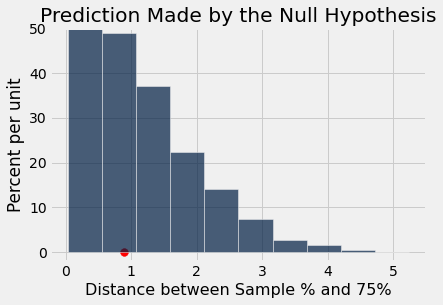

In [7]:
mendel_simulations.hist()
plots.ylim(-0.02, 0.5)
plots.title('Prediction Made by the Null Hypothesis')
plots.scatter(observed_distance, 0, color='red', s=60);

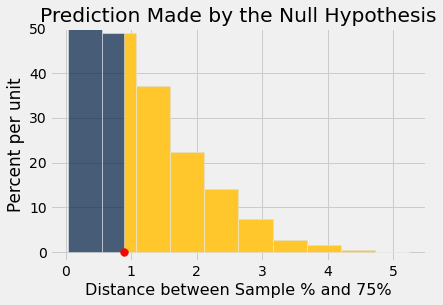

In [8]:
mendel_simulations.hist(left_end=observed_distance)
plots.ylim(-0.02, 0.5)
plots.title('Prediction Made by the Null Hypothesis')
plots.scatter(observed_distance, 0, color='red', s=60, zorder=3);

In [9]:
# Shaded area (as a proportion)

np.count_nonzero(distances >= observed_distance) / num_simulations

0.5455

## How Far is Too Far?
Suppose you decide to use the 5% cutoff.

In [10]:
np.count_nonzero(distances >= 2.85) / num_simulations

0.0461

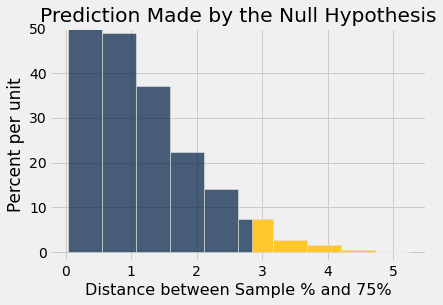

In [11]:
cutoff_5_percent = 2.85
mendel_simulations.hist(left_end=cutoff_5_percent)
plots.ylim(-0.02, 0.5)
plots.title('Prediction Made by the Null Hypothesis');

## Comparing Two Samples ##

In [12]:
births = Table.read_table('baby.csv')

In [13]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [14]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [15]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


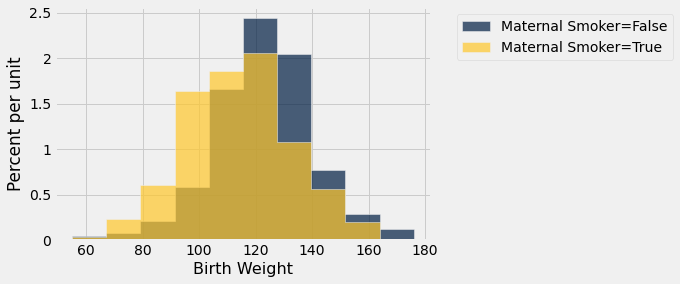

In [16]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

# Test Statistic

[Question] What values of our statistic are in favor of the alternative: positive or negative?

In [17]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [18]:
means = means_table.column('Birth Weight average')
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [19]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates which group the row relates to
    Returns: Difference of means of the two groups"""
    
    # table with the two relevant columns
    reduced = table.select('Birth Weight', group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    
    # array of group means
    means = means_table.column('Birth Weight average')
    
    return means.item(1) - means.item(0)

In [20]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

# Random Permutation (Shuffling)

In [21]:
staff = Table().with_columns(
    'Names', make_array('Jim', 'Pam', 'Dwight', 'Michael'),
    'Ages', make_array(29, 28, 34, 41)
)

In [22]:
staff.sample()

Names,Ages
Pam,28
Pam,28
Michael,41
Jim,29


In [23]:
staff.sample(with_replacement = False)

Names,Ages
Michael,41
Dwight,34
Jim,29
Pam,28


In [24]:
shuffled_names = staff.sample(with_replacement = False).column('Names')
staff.with_column('Shuffled', shuffled_names)

Names,Ages,Shuffled
Jim,29,Dwight
Pam,28,Jim
Dwight,34,Pam
Michael,41,Michael


# Simulation Under Null Hypothesis

In [25]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [26]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')

In [27]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

In [28]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,False
True,128,False
True,108,False
False,136,True
False,138,False
False,132,False
False,120,True
True,143,False
False,140,True


In [29]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

2.4565077623901175

In [30]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

# Permutation Test

In [31]:
def one_simulated_difference():
    """Returns: Difference of means of smokers vs non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of numerical variable and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

In [32]:
one_simulated_difference()

0.8002407178877888

In [33]:
differences = make_array()

for i in np.arange(1000):
    new_difference = one_simulated_difference()
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


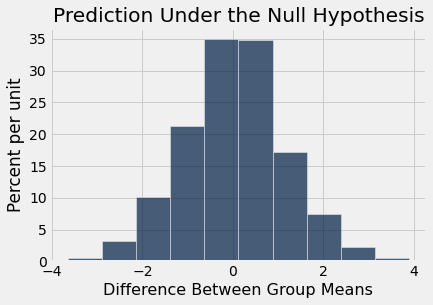

In [34]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');